<a href="https://colab.research.google.com/github/LeDucDiLac/anti-spoofing-w-dinov2/blob/main/Dinov2_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy
import os
from google.colab import drive
from torchvision.datasets import  ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from tqdm import tqdm


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


# Load the 5k Dataset provided by my company

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32

img_size = 224
img_path = "drive/MyDrive/antispoofing/5kDataset"

trans = v2.Compose([
    v2.Resize([img_size,img_size]),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


dts = ImageFolder(img_path, trans)
dtl = DataLoader(dts, batch_size = batch_size, shuffle = False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


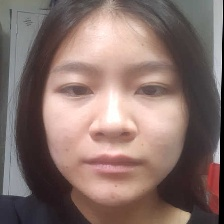

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
sample_img_path = dts.samples[0][0]
sp = cv2.imread(sample_img_path)
cv2_imshow(sp)

# Load the crowdcollected face anti- spoofing dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faber24/lcc-fasd")

print("Path to dataset files:", path)

100%|██████████| 4.84G/4.84G [00:47<00:00, 109MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1


In [ ]:
import os
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")

list_directory_tree_with_os_walk(path)

Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_training
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_training/spoof
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_training/real
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_evaluation
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_evaluation/spoof
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_evaluation/real
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development
Directory: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/spoof
Directory: /root/.cache/k

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32

img_size = 224

#Change the path file
img_path = os.path.join(path, "LCC_FASD/LCC_FASD_evaluation")
print("Loading data at:\n", img_path)
trans = v2.Compose([
    v2.Resize([img_size,img_size]),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


dts = ImageFolder(img_path, trans)
dtl = DataLoader(dts, batch_size = batch_size, shuffle = False)
print("Dataset size:", len(dts))
print(dts.class_to_idx)

Loading data at:
 /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_evaluation
Dataset size: 7580
{'real': 0, 'spoof': 1}


# Extractions without deleting caches

In [ ]:
model_name = 'dinov2_vitl14'

dinov2 = torch.hub.load('facebookresearch/dinov2', model_name)
for param in dinov2.parameters():
  param.requires_grad = False

import numpy as np
features = []
paths = []
labels =[]
dinov2.to(device).eval()
print("using", device)
for batch_idx, (images, lbs) in enumerate(tqdm(dtl, desc="Processing Images")):
    batch_start = batch_idx * dtl.batch_size
    batch_end = batch_start + len(lbs)
    batch_paths = [dts.samples[i][0] for i in range(batch_start, batch_end)]
    images = images.to(device)
    ft = dinov2(images)
    features.append(ft)
    paths.extend(batch_paths)
    labels.extend(lbs)



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:05<00:00, 226MB/s]


using cuda


Processing Images: 100%|██████████| 161/161 [04:05<00:00,  1.52s/it]


We save after extraction

In [ ]:
# Concatenate the features list and move it to the CPU
features = torch.cat(features).cpu().numpy()  # Combine tensors and convert to NumPy

# Convert labels to a NumPy array
labels = torch.tensor(labels).cpu().numpy()  # Convert to tensor, then NumPy
ft_path = "/content/drive/MyDrive/antispoofing/features_l14.npy"
paths_path = "/content/drive/MyDrive/antispoofing/paths_l14.npy"
labels_path = "/content/drive/MyDrive/antispoofing/labels_l14.npy"

# Save features, paths, and labels
np.save(ft_path, features)
np.save(paths_path, np.array(paths))
np.save(labels_path, labels)


# Extraction progressively batch by batch, by freeing up memory after each batch

The g14 model is a huge one, we can't afford just training the whole dataset

In [ ]:
import os
import numpy as np
import torch
from tqdm import tqdm

# Define model
model_name = 'dinov2_vitg14'
dinov2 = torch.hub.load('facebookresearch/dinov2', model_name)
for param in dinov2.parameters():
    param.requires_grad = False
dinov2.to(device).eval()
print("Using device:", device)



Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [01:28<00:00, 51.3MB/s]


Using device: cpu
Saving features at: /content/drive/MyDrive/antispoofing/features_LCC_FASD_g14.npy


In [ ]:
# Modify the dts name
dts_name = "LCC_eval"
dir_path = "/content/drive/MyDrive/antispoofing/"
ft_path = os.path.join(dir_path, "features-" + dts_name + "-"  + model_name +".npy")
paths_path = os.path.join(dir_path, "paths-" + dts_name + "-"  + model_name +".npy")
labels_path = os.path.join(dir_path, "labels-" + dts_name + "-"  + model_name +".npy")

print("Saving features at:", ft_path)

Saving features at: /content/drive/MyDrive/antispoofing/features-LCC_eval-dinov2_vitg14.npy


In [ ]:

# Create empty files to save outputs incrementally
np.save(ft_path, np.empty((0, 1536), dtype=np.float32))  # Replace 768 with the correct feature dimension
np.save(paths_path, np.empty((0,), dtype=object))
np.save(labels_path, np.empty((0,), dtype=int))

# Inference loop
for batch_idx, (images, lbs) in enumerate(tqdm(dtl, desc="Processing Images")):
    batch_start = batch_idx * dtl.batch_size
    batch_end = batch_start + len(lbs)
    batch_paths = [dts.samples[i][0] for i in range(batch_start, batch_end)]

    # Move images to device and perform inference
    images = images.to(device)
    with torch.no_grad():
        ft = dinov2(images).cpu().numpy()  # Move features to CPU

    # Append results to the files
    existing_features = np.load(ft_path, allow_pickle=True)
    existing_paths = np.load(paths_path, allow_pickle=True)
    existing_labels = np.load(labels_path, allow_pickle=True)

    np.save(ft_path, np.vstack([existing_features, ft]))
    np.save(paths_path, np.concatenate([existing_paths, np.array(batch_paths)]))
    np.save(labels_path, np.concatenate([existing_labels, lbs.numpy()]))

    # Clear memory
    del images, lbs, ft
    torch.cuda.empty_cache()


Processing Images:   0%|          | 0/237 [04:51<?, ?it/s]


KeyboardInterrupt: 